In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pymc3 as pm
from pymc3.gp.util import plot_gp_dist
import scipy as sp
import pyccl as ccl
import theano
import theano.tensor as tt
import os
import utils
from make_data import MakeData
from scipy.linalg import block_diag
theano.config.exception_verbosity='high'
%matplotlib inline

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


# Settings

In [2]:
z_max = 1110
res = 200
x_arr = np.linspace(0, np.log(1+z_max), res)
dx = np.mean(np.diff(x_arr))
z_arr = np.exp(x_arr)-1
a_arr = 1./(1+z_arr)

path = '/home/jaimerz/PhD/Growz/data/products' 
challenge = None #'cosmo51'
if challenge is not None:
    path += 'challenge/'+'cosmo{}_seed100{}'.format(challenge[-2], challenge[-1])

print('data path: ', path)
mean_path =  None #'LCDM_cosmo44_10000_10000'
mean_mode = 'Planck'
data_class = MakeData(z_max, res, path,
                      cosmo_mode=mean_mode,
                      cosmo_path=mean_path)
c = data_class.c

DESI = data_class.get_DESI(new=True, mode=None)
geo_DESI = data_class.get_DESI(new=True, mode='geo')
gro_DESI = data_class.get_DESI(new=True, mode='gro')
WFIRST = data_class.get_WFIRST(new=True)
CC = data_class.get_CC(new=False)
DSS = data_class.get_DSS(new=False)
BOSS = data_class.get_BOSS(new=False)
geo_BOSS = data_class.get_BOSS(new=False, mode='geo')
gro_BOSS = data_class.get_BOSS(new=False, mode='gro')
eBOSS = data_class.get_eBOSS(new=False)
geo_eBOSS = data_class.get_eBOSS(new=False, mode='geo')
gro_eBOSS = data_class.get_eBOSS(new=False, mode='gro')
Wigglez = data_class.get_Wigglez(new=False)
DS17 = data_class.get_DS17(new=False)
CMB = data_class.get_CMB(new=False)

n_samples = 100
n_tune = 100
Planck = data_class.Planck
z_planck = data_class.z_planck

datadict = {'DESI': DESI,
            'geo_DESI': geo_DESI,
            'gro_DESI': gro_DESI,
            'WFIRST': WFIRST,
            'CC': CC,
            'DS17': DS17, 
            'BOSS': BOSS,
            'geo_BOSS': geo_BOSS,
            'gro_BOSS': gro_BOSS,
            'eBOSS': eBOSS,
            'geo_eBOSS': geo_eBOSS,
            'gro_eBOSS': gro_eBOSS,
            'Wigglez': Wigglez,
            'DSS': DSS,
            'CMB': CMB}

data_comb = 'All_CMB_geo' # All, All_CMB, SDSS, SDSS_CMB, Add, Add_CMB
data_combs = {'All': ['CC', 'DS17', 'BOSS', 'eBOSS', 'Wigglez', 'DSS'],
             'All_CMB': ['CC', 'DS17', 'BOSS', 'eBOSS', 'Wigglez', 'DSS', 'CMB'],
             'All_CMB_NODSS': ['CC', 'DS17', 'BOSS', 'eBOSS', 'Wigglez', 'CMB'],
             'All_CMB_geo': ['CC', 'DS17', 'geo_BOSS', 'geo_eBOSS', 'CMB'],
             'All_gro': ['gro_BOSS', 'gro_eBOSS', 'Wigglez', 'DSS'],
             'All_CMB_gro': ['gro_BOSS', 'gro_eBOSS', 'Wigglez', 'DSS', 'CMB'],
             'SDSS': ['BOSS', 'eBOSS'],
             'SDSS_CMB': ['BOSS', 'eBOSS', 'CMB'],
             'Add': ['CC', 'DS17', 'Wigglez', 'DSS'],
             'Add_CMB': ['CC', 'DS17', 'Wigglez', 'DSS', 'CMB'],
             'DESI_CMB': ['DESI', 'CMB'], 
             'DESI_CMB_geo': ['geo_DESI', 'CMB'], 
             'DESI_gro': ['gro_DESI'], 
             'WFIRST_CMB': ['WFIRST', 'CMB']}
datasets = data_combs[data_comb]

need_dM = ['DESI', 'geo_DESI', 'BOSS', 'eBOSS', 'geo_BOSS', 'geo_eBOSS',
           'Wigglez', 'DS17', 'CMB', 'FCMB']
need_fs8 = ['DESI', 'gro_DESI', 'BOSS', 'eBOSS', 'gro_BOSS', 
            'gro_eBOSS', 'Wigglez', 'DSS']
need_rd = ['BOSS', 'eBOSS', 'geo_BOSS', 'geo_eBOSS', 'CMB']

if any(dataset in datasets for dataset in need_dM):
    get_dM=True 
else:
    get_dM=False
    
if any(dataset in datasets for dataset in need_fs8):
    get_fs8=True
else:
    get_fs8=False
    
if any(dataset in datasets for dataset in need_rd):
    get_rd = True
else:
    get_rd = False
        
#Data
data = np.array([])
data_cov = np.array([])
for dataset_name in datasets:
    dataset = datadict[dataset_name]
    data = np.concatenate([data, dataset['data']])
    data_cov = block_diag(data_cov, dataset['cov'])
data_cov = data_cov[1:]

data path:  /home/jaimerz/PhD/Growz/data/products
Using Planck mean
Found file for CC
Found file for DSS
Found file for BOSS
Found file for geoBOSS
Found file for groBOSS
Found file for eBOSS
Found file for geoeBOSS
Found file for groeBOSS
Found file for Wigglez
Found file for DS17
Found file for CMB


# Model

In [3]:
with pm.Model() as model:
    ℓ = pm.Uniform("ℓ", 0.01, 6) 
    η = pm.HalfNormal("η", sigma=0.2) 
    A0 = pm.Normal("A0", 1, 0.2)
    wm0_mean = data_class.wm0 
    wr0 = data_class.wr0
    wL0 = data_class.wL0 
    gp_cov = η ** 2 * pm.gp.cov.ExpQuad(1, ℓ) + pm.gp.cov.WhiteNoise(1e-5)
    gp = pm.gp.Latent(cov_func=gp_cov)
    
    #Mean of the gp
    H = pm.Deterministic('H', 100*tt.sqrt(wm0_mean*(1+z_arr)**3+wr0*(1+z_arr)**4+wL0))
    
    #Set up Gaussian process
    DH_gp = gp.prior("DH_gp", X=x_arr[:, None]) 
    H_gp = pm.Deterministic("H_gp", tt.as_tensor_variable(A0*H*(1+DH_gp)))
    H0_gp = pm.Deterministic("H0_gp", tt.as_tensor_variable(H_gp[0]))
    
    if get_dM:
        dH_gp = pm.Deterministic("dH", tt.as_tensor_variable((c/1000)/H_gp))
        dM_rec_gp = tt.zeros(len(z_arr)+1)
        dM_rec_gp = tt.inc_subtensor(dM_rec_gp[1:],
                  tt.as_tensor_variable(dx*tt.cumsum(dH_gp*(1+z_arr))))
        dM_trap_gp = tt.as_tensor_variable(0.5*(dM_rec_gp[1:]+dM_rec_gp[:-1])-0.5*dM_rec_gp[1])
        dM_gp = pm.Deterministic('dM_gp', dM_trap_gp)
        dA_gp = pm.Deterministic('dA_gp', dM_gp/(1+z_arr))
        dL_gp = pm.Deterministic('dL_gp', dM_gp*(1+z_arr))
        
    if get_rd:
        rd_gp = pm.Normal("rd_gp", 150, 5)
        
    if get_fs8:
        Wm0 = pm.Uniform("Wm0", 0., 1.)
        s80 = pm.Normal("s80", 0.8, 0.5)
        E = H_gp/H_gp[0]
        xx = x_arr[::-1]
        ee = E[::-1]
        aa = np.exp(-xx)
        dx = np.mean(np.diff(xx))

        nz = len(aa)
        dd = tt.zeros(nz)
        yy = tt.zeros(nz)
        dd = tt.inc_subtensor(dd[0], aa[0])
        yy = tt.inc_subtensor(yy[0], aa[0]**3*E[0])

        for i in range(nz-1):
            A0 = -1.5*Wm0/(aa[i]*ee[i])
            B0 = -1./(aa[i]**2*ee[i])
            A1 = -1.5*Wm0/(aa[i+1]*ee[i+1])
            B1 = -1./(aa[i+1]**2*ee[i+1])
            yy = tt.inc_subtensor(yy[i+1], (1+0.5*dx**2*A0*B0)*yy[i]+0.5*(A0+A1)*dx*dd[i])
            dd = tt.inc_subtensor(dd[i+1],0.5*(B0+B1)*dx*yy[i]+(1+0.5*dx**2*A0*B0)*dd[i])
        
        y = tt.as_tensor_variable(yy[::-1])
        d = tt.as_tensor_variable(dd[::-1])
        
        fs8_gp = pm.Deterministic('fs8_gp', s80*y/(a_arr**2*E*d[0]))
        s8_gp = pm.Deterministic('s8_gp', s80*d/d[0])
        
    theory = tt.as_tensor_variable([])
    
#Modules
if 'DESI' in datasets:
    print('Adding DESI')
    with model:
        DESI_H = pm.Deterministic('DESI_H',
                 tt.as_tensor_variable(H_gp[DESI['idx']]+(H_gp[DESI['idx']+1]-H_gp[DESI['idx']])*DESI['U']))
        DESI_dA = pm.Deterministic('DESI_dA',
                  tt.as_tensor_variable(dA_gp[DESI['idx']]+(dA_gp[DESI['idx']+1]-dA_gp[DESI['idx']])*DESI['U']))
        DESI_fs8 = pm.Deterministic('DESI_fs8',
                   tt.as_tensor_variable(fs8_gp[DESI['idx']]+(fs8_gp[DESI['idx']+1]-fs8_gp[DESI['idx']])*DESI['U']))
        theory = tt.concatenate([theory, DESI_H, DESI_dA, DESI_fs8])

if 'gro_DESI' in datasets:
    print('Adding DESI_gro')
    with model:
        DESI_fs8 = pm.Deterministic('DESI_fs8',
                   tt.as_tensor_variable(fs8_gp[DESI['idx']]+(fs8_gp[DESI['idx']+1]-fs8_gp[DESI['idx']])*DESI['U']))
        theory = tt.concatenate([theory, DESI_fs8])

if 'geo_DESI' in datasets:
    print('Adding DESI_geo')
    with model:
        DESI_H = pm.Deterministic('DESI_H',
                 tt.as_tensor_variable(H_gp[DESI['idx']]+(H_gp[DESI['idx']+1]-H_gp[DESI['idx']])*DESI['U']))
        DESI_dA = pm.Deterministic('DESI_dA',
                  tt.as_tensor_variable(dA_gp[DESI['idx']]+(dA_gp[DESI['idx']+1]-dA_gp[DESI['idx']])*DESI['U']))
        theory = tt.concatenate([theory, DESI_H, DESI_dA])
        
if 'WFIRST' in datasets:
    print('Adding WFIRST')
    with model:
        WFIRST_E = pm.Deterministic('WFIRST_E',
                   tt.as_tensor_variable(E_gp[WFIRST['idx']]+(E_gp[WFIRST['idx']+1]-E_gp[WFIRST['idx']])*WFIRST['U']))
        theory = tt.concatenate([theory, WFIRST_E])

if 'CC' in datasets:
    print('Adding CCs')
    with model:
        CC_H = pm.Deterministic("CC_H",
               tt.as_tensor_variable(H_gp[CC['idx']]+(H_gp[CC['idx']+1]-H_gp[CC['idx']])*CC['U']))
        theory = tt.concatenate([theory, CC_H])
        
if 'DS17' in datasets:
    print('Adding Pantheon')
    with model:
        M = pm.Normal('M', mu=-19.0, sigma=3)
        DS17_dL = tt.as_tensor_variable(dL_gp[DS17['idx']]+(dL_gp[DS17['idx']+1]-dL_gp[DS17['idx']])*DS17['U'])
        DS17_u = pm.Deterministic("DS17_dL",
                 tt.as_tensor_variable(5*tt.log10(DS17_dL)+25+M))
        theory = tt.concatenate([theory, DS17_u])
        
if 'BOSS' in datasets:
    print('Adding BOSS')
    with model:
        B_H = tt.as_tensor_variable(H_gp[BOSS['idx']]+(H_gp[BOSS['idx']+1]-H_gp[BOSS['idx']])*BOSS['U'])
        B_dM = tt.as_tensor_variable(dM_gp[BOSS['idx']]+(dM_gp[BOSS['idx']+1]-dM_gp[BOSS['idx']])*BOSS['U'])
        B_fs8 = pm.Deterministic("B_fs8", 
                   tt.as_tensor_variable(fs8_gp[BOSS['idx']]+(fs8_gp[BOSS['idx']+1]-fs8_gp[BOSS['idx']])*BOSS['U']))
        #Get alpha_perp and alpha_para 
        B_para = pm.Deterministic("B_para", B_H*rd_gp/BOSS['rd'])
        B_perp = pm.Deterministic("B_perp", B_dM*BOSS['rd']/rd_gp)
        theory = tt.concatenate([theory, B_para, B_perp, B_fs8])
        
if 'geo_BOSS' in datasets:
    print('Adding geo_BOSS')
    with model:
        B_H = tt.as_tensor_variable(H_gp[BOSS['idx']]+(H_gp[BOSS['idx']+1]-H_gp[BOSS['idx']])*BOSS['U'])
        B_dM = tt.as_tensor_variable(dM_gp[BOSS['idx']]+(dM_gp[BOSS['idx']+1]-dM_gp[BOSS['idx']])*BOSS['U'])
        #Get alpha_perp and alpha_para 
        B_para = pm.Deterministic("B_para", B_H*rd_gp/BOSS['rd'])
        B_perp = pm.Deterministic("B_perp", B_dM*BOSS['rd']/rd_gp)
        theory = tt.concatenate([theory, B_para, B_perp])
        
if 'gro_BOSS' in datasets:
    print('Adding gro_BOSS')
    with model:
        B_fs8 = pm.Deterministic("B_fs8", 
                   tt.as_tensor_variable(fs8_gp[BOSS['idx']]+(fs8_gp[BOSS['idx']+1]-fs8_gp[BOSS['idx']])*BOSS['U']))
        theory = tt.concatenate([theory, B_fs8])
        
if 'eBOSS' in datasets:
    print('Adding eBOSS')
    with model:
        eB_dH = tt.as_tensor_variable(dH_gp[eBOSS['idx']]+(dH_gp[eBOSS['idx']+1]-dH_gp[eBOSS['idx']])*eBOSS['U'])
        eB_dM = tt.as_tensor_variable(dM_gp[eBOSS['idx']]+(dM_gp[eBOSS['idx']+1]-dM_gp[eBOSS['idx']])*eBOSS['U'])
        eB_fs8 = pm.Deterministic("eB_fs8", 
                   tt.as_tensor_variable(fs8_gp[eBOSS['idx']]+(fs8_gp[eBOSS['idx']+1]-fs8_gp[eBOSS['idx']])*eBOSS['U']))
        eB_para = pm.Deterministic("eB_para", eB_dH/rd_gp)
        eB_perp = pm.Deterministic("eB_perp", eB_dM/rd_gp)
        theory = tt.concatenate([theory, eB_para, eB_perp, eB_fs8])
        
if 'geo_eBOSS' in datasets:
    print('Adding geo_eBOSS')
    with model:
        eB_dH = tt.as_tensor_variable(dH_gp[eBOSS['idx']]+(dH_gp[eBOSS['idx']+1]-dH_gp[eBOSS['idx']])*eBOSS['U'])
        eB_dM = tt.as_tensor_variable(dM_gp[eBOSS['idx']]+(dM_gp[eBOSS['idx']+1]-dM_gp[eBOSS['idx']])*eBOSS['U'])
        eB_para = pm.Deterministic("eB_para", eB_dH/rd_gp)
        eB_perp = pm.Deterministic("eB_perp", eB_dM/rd_gp)
        theory = tt.concatenate([theory, eB_para, eB_perp])

if 'gro_eBOSS' in datasets:
    print('Adding gro_eBOSS')
    with model:
        eB_fs8 = pm.Deterministic("eB_fs8", 
                   tt.as_tensor_variable(fs8_gp[eBOSS['idx']]+(fs8_gp[eBOSS['idx']+1]-fs8_gp[eBOSS['idx']])*eBOSS['U']))
        theory = tt.concatenate([theory, eB_fs8])

if 'Wigglez' in datasets:
    print('Adding Wigglez')
    with model:
        Wigglez_fs8 = pm.Deterministic("Wigglez_fs8",
                    tt.as_tensor_variable(fs8_gp[Wigglez['idx']]+(fs8_gp[Wigglez['idx']+1]-fs8_gp[Wigglez['idx']])*Wigglez['U']))
        theory = tt.concatenate([theory, Wigglez_fs8])

if 'DSS' in datasets:
    print('Adding DSS')
    with model:
        DSS_fs8 = pm.Deterministic("fs8_eBOSS", tt.as_tensor_variable(fs8_gp[DSS['idx']]))
        theory = tt.concatenate([theory, DSS_fs8])

if 'CMB' in datasets:
    print('Adding CMB')
    with model:
        dM_star = tt.as_tensor_variable(dM_gp[CMB['idx']]+(dM_gp[CMB['idx']+1]-dM_gp[CMB['idx']])*CMB['U'])
        t100 = pm.Deterministic('t100', 100*rd_gp/dM_star) 
        theory = tt.concatenate([theory, t100])

Adding CCs
Adding Pantheon
Adding geo_BOSS
Adding geo_eBOSS
Adding CMB


In [4]:
#Sampling
with model:
    lkl= pm.MvNormal("lkl", mu=theory, cov=data_cov, observed=data)
    trace = pm.sample(n_samples, return_inferencedata=True, tune=n_tune, target_accept=0.95)

Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [M, rd_gp, DH_gp_rotated_, A0, η, ℓ]


Sampling 4 chains for 100 tune and 100 draw iterations (400 + 400 draws total) took 1288 seconds.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The number of effective samples is smaller than 10% for some parameters.


In [5]:
#print r-stat
print(pm.summary(trace)['r_hat'][["Wm0", "η"]])
print(pm.summary(trace)['mean'][["Wm0", "ℓ", "η"]])

/home/jaimerz/.local/lib/python3.8/site-packages/arviz/stats/diagnostics.py:561: RuntimeWarning: invalid value encountered in double_scalars
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/home/jaimerz/.local/lib/python3.8/site-packages/arviz/stats/diagnostics.py:561: RuntimeWarning: invalid value encountered in double_scalars
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/home/jaimerz/.local/lib/python3.8/site-packages/arviz/stats/diagnostics.py:561: RuntimeWarning: invalid value encountered in double_scalars
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/home/jaimerz/.local/lib/python3.8/site-packages/arviz/stats/diagnostics.py:561: RuntimeWarning: invalid value encountered in double_scalars
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


KeyError: 'Passing list-likes to .loc or [] with any missing labels is no longer supported, see https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike'

In [16]:
#Save
filename = data_comb
if mean_mode is not None:
    filename += '_'+mean_mode
if challenge is not None:
    filename += '_'+challenge
    
filename += '_{}_{}'.format(n_samples, n_tune)
print(filename)

n = np.array(trace.posterior["η"]).flatten()
l = np.array(trace.posterior["ℓ"]).flatten()
A0 = np.array(trace.posterior["A0"]).flatten()
DHz = np.array(trace.posterior["DH_gp"])
DHz = DHz.reshape(-1, DHz.shape[-1])
Hz =np.array(trace.posterior["H_gp"])
Hz = Hz.reshape(-1, Hz.shape[-1])
H0_gp = np.array(trace.posterior["H0_gp"]).flatten()

if get_dM:
    dMz = np.array(trace.posterior["dM_gp"])
    dMz = dMz.reshape(-1, dMz.shape[-1])
else:
    dMz = None

if get_rd:
    rd = np.array(trace.posterior["rd_gp"]).flatten()
else:
    rd = None
    
if get_fs8:
    s8z = np.array(trace.posterior["s8_gp"])
    s8z = s8z.reshape(-1, s8z.shape[-1])
    fs8z = np.array(trace.posterior["fs8_gp"])
    fs8z = fs8z.reshape(-1, fs8z.shape[-1])
    Omega_m = np.array(trace.posterior["Wm0"]).flatten()
    s80 = np.array(trace.posterior["s80"]).flatten()
    S80 = s80*np.sqrt(Omega_m/0.3)
else: 
    s8z = None 
    fs8z = None
    Omega_m = None
    s80 = None
    S80 = None

if 'DS17' in datasets:
    M = np.array(trace.posterior["M"]).flatten()
else:
    M = None

os.mkdir(filename)
np.savez(os.path.join(filename,'samples.npz'), 
         z_arr = z_arr,
         n=n,
         l=l,
         A0=A0,
         DHz = DHz,
         Hz=Hz,
         dMz=dMz,
         s8z=s8z,
         fs8z=fs8z,
         H0_gp=H0_gp,
         Omega_m=Omega_m,
         s80=s80,
         S80=S80,
         rd=rd,
         M=M)

All_CMB_geo_Planck_100_100


In [7]:
def get_m_s(rows):
    cols = np.transpose(rows)
    means = np.array([])
    sigmas = np.array([])
    for col in cols:
        mean = np.mean(col)
        sigma = np.std(col)
        means = np.append(means, mean)
        sigmas = np.append(sigmas, sigma)
    return means, sigmas

In [8]:
DHz = np.array(trace.posterior["DH_gp"])
DHz = DHz.reshape(-1, DHz.shape[-1])
DH_m, DH_s = get_m_s(DHz)

<ipython-input-9-e9a500463658>:5: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  plt.xlim(0, 1110)


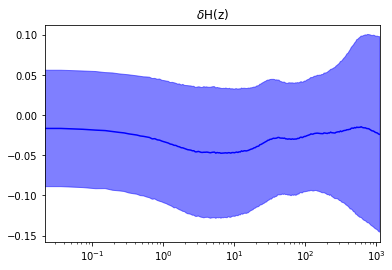

In [9]:
plt.plot(z_arr,  DH_m, color ='b')
plt.fill_between(z_arr, DH_m+DH_s,
                 DH_m-DH_s, color='b', alpha=.5)
plt.xscale('log')
plt.xlim(0, 1110)
plt.title('$\delta$H(z)')
plt.show()

NameError: name 'H_DESI' is not defined

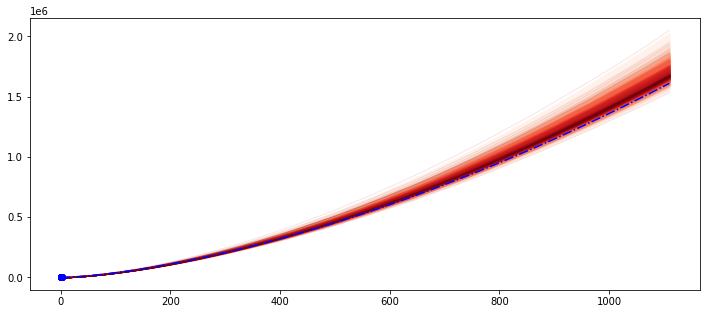

In [10]:
# plot the results
fig = plt.figure(figsize=(12, 5))
ax = fig.gca()

plot_gp_dist(ax, trace.posterior["H_gp"][0, :, :], z_arr[:, None])
plt.plot(z_arr, data_class.H_arr, 'b-.', label='formula')

# plot the data and the true latent function
#ax.plot(z_arr_f[:, None], H_arr_f, "dodgerblue", lw=3, label=r'$LCDM$')
if 'CC' in datasets:
    plt.errorbar(CC['z'], CC['data'], yerr = CC['err'], fmt='bo', label='CC')
if 'FCMB' in datasets:
    plt.errorbar(FCMB['z'], FCMB['data'], yerr = FCMB['err'], fmt='go', label='FCMB')
if 'BOSS' in datasets:
    plt.errorbar(BOSS['z'], BOSS['para_data'], yerr=BOSS['para_err'], fmt='ro', label='BOSS')
if 'eBOSS' in datasets:
    plt.errorbar(eBOSS['z'], c/1000/(eBOSS['para_data']*eBOSS['rd']), yerr = 1/eBOSS['rd']/(np.array([0.47])), fmt='mo', label='eBOSS')
if 'DESI' or 'H_DESI' in datasets:
    plt.errorbar(H_DESI['z'], H_DESI['data'], yerr = H_DESI['err'], fmt='bo', label='DESI')

# axis labels and title
plt.xlim(0, 2.5)
plt.ylim(50, 300)
plt.xlabel("z")
plt.ylabel("H(z)")
plt.title("H(z)")
plt.legend();

In [11]:
from getdist import plots, MCSamples
def make_samples(file, names, ranges, label):
    namess = []
    labels = []
    samples = []
    for name in names:
        if name in file.keys():
            namess.append(name) 
            labels.append(labels_dict[name]) 
            samples.append(file[name]) 
        
    return MCSamples(samples=samples, names=namess, labels=labels, label=label, ranges=ranges,
                    settings={'mult_bias_correction_order':0,'smooth_scale_2D':0.3, 'smooth_scale_1D':0.3})

In [12]:
labels_dict = {'n': '\eta',
               'l': 'l',
               'A0': 'A_0',
               'n_H': '\eta_H',
               'l_H': 'l_H',
               'n_Xi': '\eta_{Xi}',
               'l_Xi': 'l_{Xi}',
               'H0': 'H_0',
               'H0_gp': 'H_0',
               'omega_m': '\omega_m',
               'Omega_m': '\Omega_m',
               'Omega_m_mean': '\Omega_m^{mean}',
               'omega_b': '\omega_b',
               'Omega_m': '\Omega_m',
               'Omega_b': '\Omega_b',
               's80': '\sigma_8',
               'S80': 'S_8',
               'rd': 'r_s',
               'M': 'M'}
names_All = ['n', 'l', 'n_H', 'l_H', 'n_Xi', 'l_Xi', 'A0',
             'H0', 'H0_gp',  'Omega_m', 'omega_m', 'Omega_m_mean',
             'omega_b', 'Omega_m', 'Omega_b', 's80', 'S80', 'M']
#ranges = {'l':[0.001, 7], 'omega_b': [0.022, 0.023]}
ranges = {'l':[0.001, 7], 'Omega_m':[0.00, 0.4], 'omega_b':[0.015, 0.03]}

In [13]:
run = np.load(filename+'/samples.npz')

FileNotFoundError: [Errno 2] No such file or directory: 'All_CMB_geo_Planck_A0_100_100/samples.npz'

In [14]:
run_samples = make_samples(run, ['n', 'l', 'Omega_m', 's80', 'S80'],
                               ranges, 'Fiducial - CMB')

NameError: name 'run' is not defined

In [15]:
g = plots.getSubplotPlotter(subplot_size=2.5)
g.triangle_plot([run_samples],
                filled=True,
                markers={'H0':100*data_class.cosmo.h(),
                         'omega_m': data_class.cosmo.Omega_m()*data_class.cosmo.h()**2,
                         's80': data_class.cosmo.sigma8(), 
                         'S80': data_class.cosmo.sigma8()*np.sqrt(data_class.cosmo.Omega_m()/0.3)})

NameError: name 'run_samples' is not defined